In [1]:
from transformers import BertConfig
from gnn import GNNTrainer
from movie_lens_loader import MovieLensLoader
from llm import PromptBertClassifier, VanillaBertClassifier, AddingEmbeddingsBertClassifierBase

import itertools

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from torch.utils.data import DataLoader
import networkx as nx

In [2]:
config = BertConfig.from_pretrained("google/bert_uncased_L-2_H-128_A-2")
KGE_DIMENSION_PROMPT = 4
KGE_DIMENSION_ADDING = 128
KGE_DIMENSIONS = [KGE_DIMENSION_PROMPT, KGE_DIMENSION_ADDING] # Output Dimension of the GNN Encoder.
model_max_length = 256
movie_lens_loader = MovieLensLoader(kge_dimensions = KGE_DIMENSIONS)
gnn_trainer_prompt =    GNNTrainer(movie_lens_loader.data, kge_dimension = KGE_DIMENSION_PROMPT)
gnn_trainer_prompt.get_embeddings(movie_lens_loader)
gnn_trainer_adding =    GNNTrainer(movie_lens_loader.data, hidden_channels=KGE_DIMENSION_ADDING, kge_dimension = KGE_DIMENSION_ADDING)
gnn_trainer_adding.get_embeddings(movie_lens_loader)
vanilla_bert_only_classifier = VanillaBertClassifier(movie_lens_loader.llm_df,model_max_length = model_max_length)
dataset_vanilla = movie_lens_loader.generate_vanilla_dataset(vanilla_bert_only_classifier.tokenize_function)
prompt_bert_only_classifier = PromptBertClassifier(movie_lens_loader, gnn_trainer_prompt.get_embedding, kge_dimension=gnn_trainer_prompt.kge_dimension, batch_size=64,model_max_length = 512)
dataset_prompt = movie_lens_loader.generate_prompt_embedding_dataset(prompt_bert_only_classifier.tokenize_function, kge_dimension = prompt_bert_only_classifier.kge_dimension)
adding_embedding_bert_only_classifier = AddingEmbeddingsBertClassifierBase(movie_lens_loader, gnn_trainer_adding.get_embedding, kge_dimension=config.hidden_size, batch_size=64,model_max_length = model_max_length)
dataset_adding_embedding = movie_lens_loader.generate_adding_embedding_dataset(adding_embedding_bert_only_classifier.tokenizer.sep_token, adding_embedding_bert_only_classifier.tokenizer.pad_token, adding_embedding_bert_only_classifier.tokenize_function, kge_dimension = config.hidden_size)

loading pretrained model
Device: 'cpu'
loading pretrained model
Device: 'cpu'


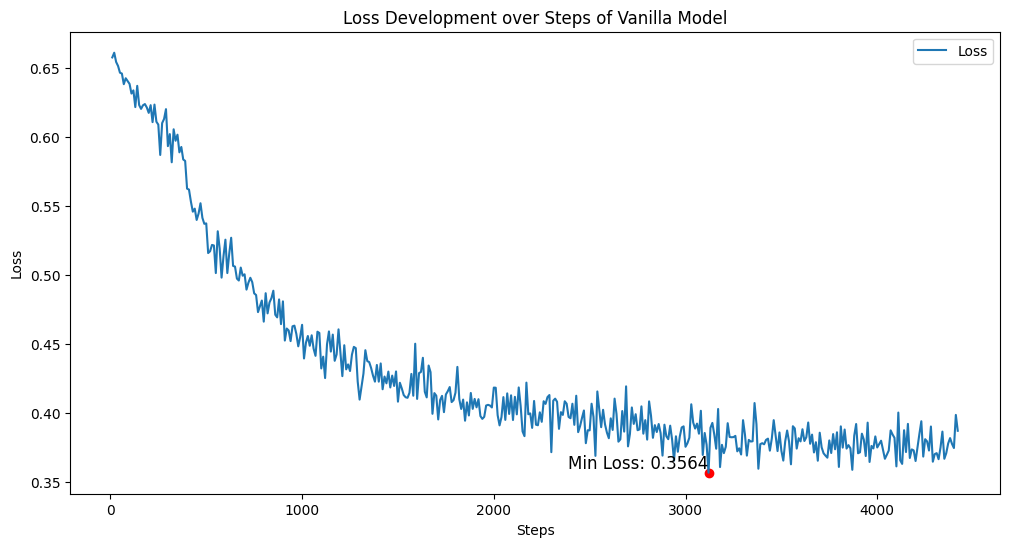

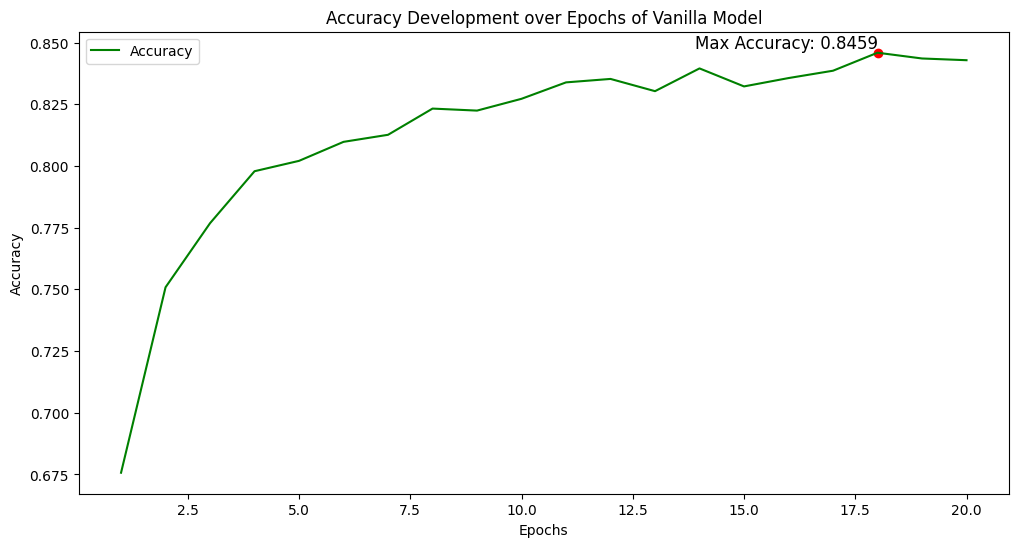

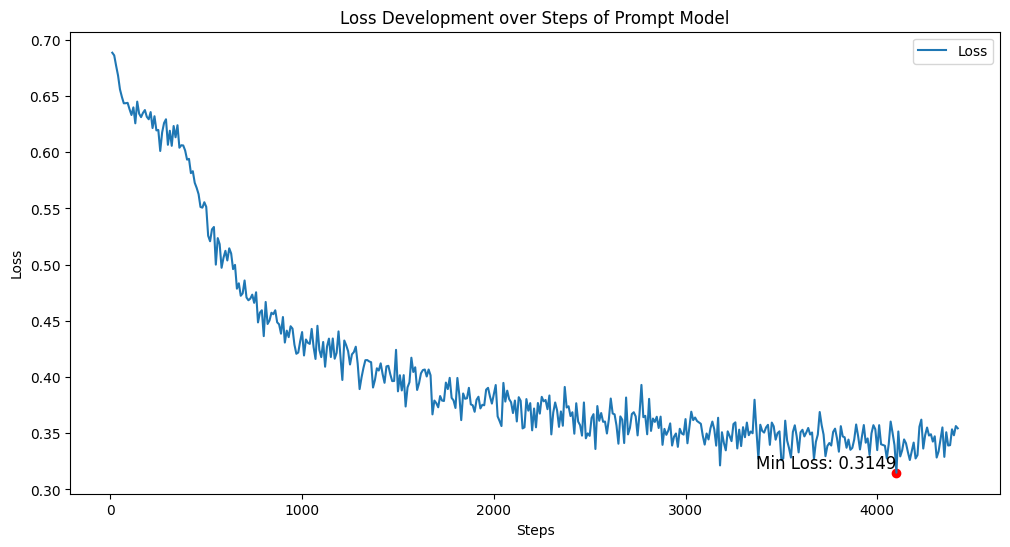

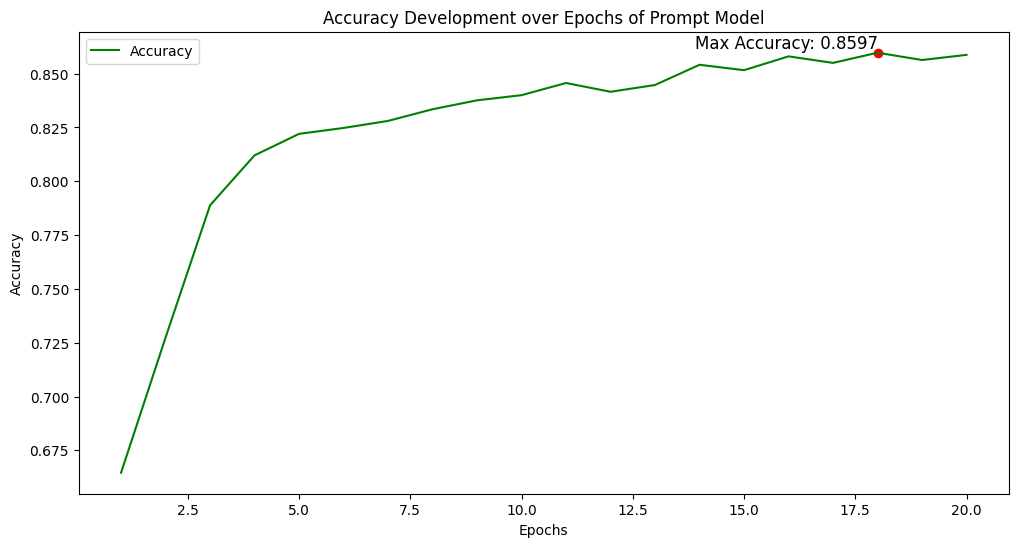

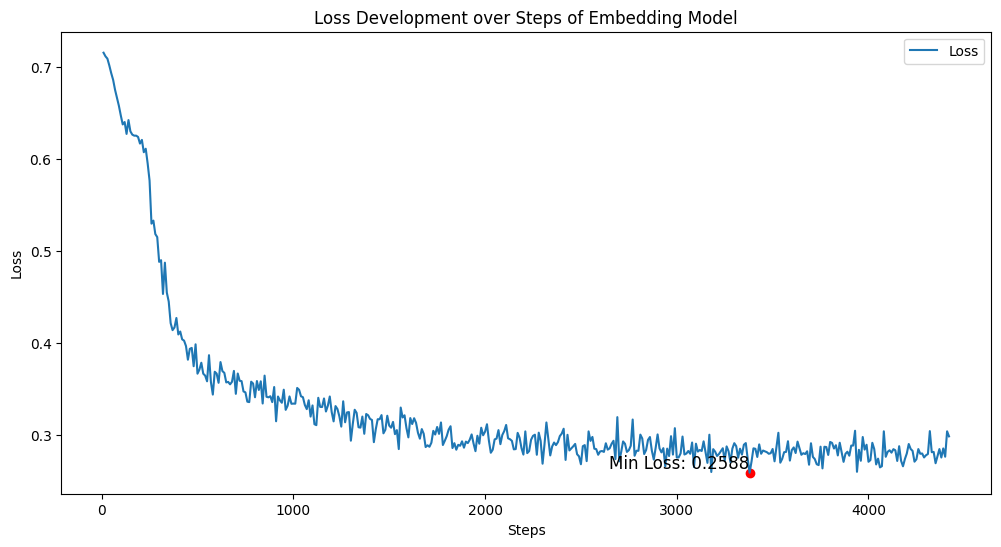

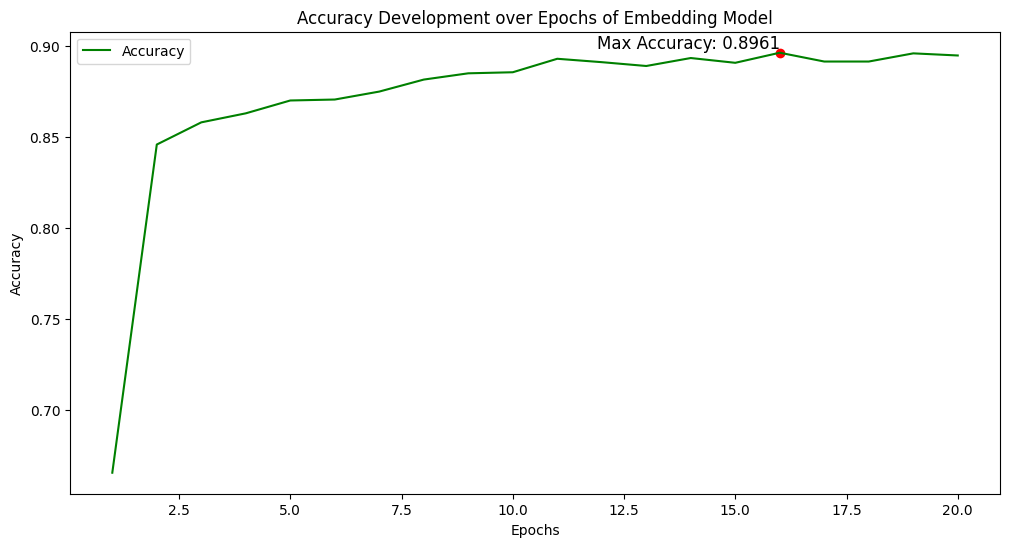

In [3]:
vanilla_bert_only_classifier.plot_training_loss_and_accuracy()
prompt_bert_only_classifier.plot_training_loss_and_accuracy()
adding_embedding_bert_only_classifier.plot_training_loss_and_accuracy()

  0%|          | 0/268 [00:00<?, ?it/s]

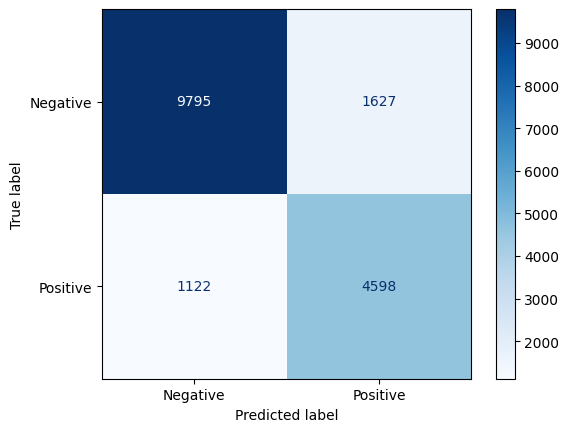

  0%|          | 0/268 [00:00<?, ?it/s]

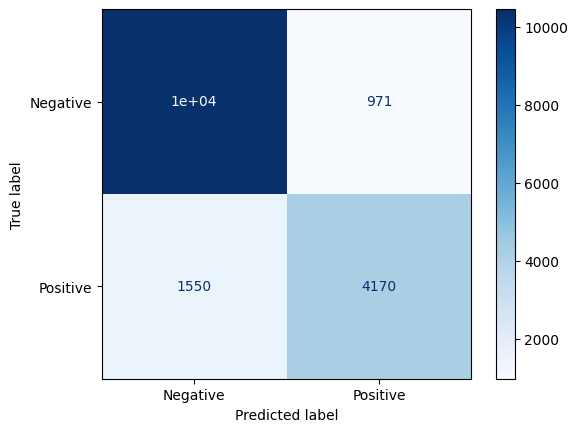

  0%|          | 0/268 [00:00<?, ?it/s]

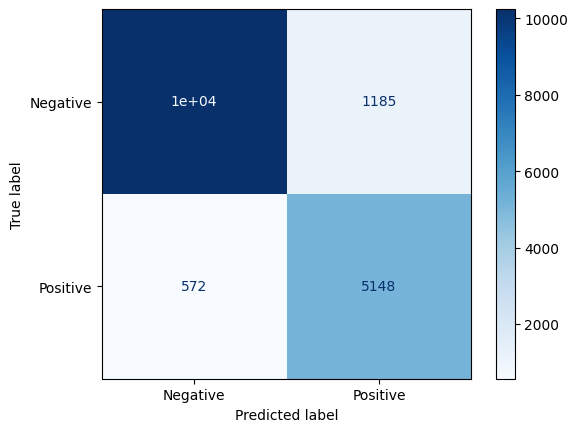

In [4]:
vanilla_bert_only_classifier.plot_confusion_matrix(split = "val", dataset = dataset_vanilla)
prompt_bert_only_classifier.plot_confusion_matrix(split = "val", dataset = dataset_prompt)
adding_embedding_bert_only_classifier.plot_confusion_matrix(split = "val", dataset = dataset_adding_embedding)
